# Image Compression

In [104]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.image as image
from matplotlib.image import imread
from matplotlib import pyplot as plt
from scipy.fftpack import fft, dct, idct
import math
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.cm as cm

####TASK 1 --- Divide into 8 by 8 blocks, which is what jpeg used.

471 640 and (471, 640, 3)


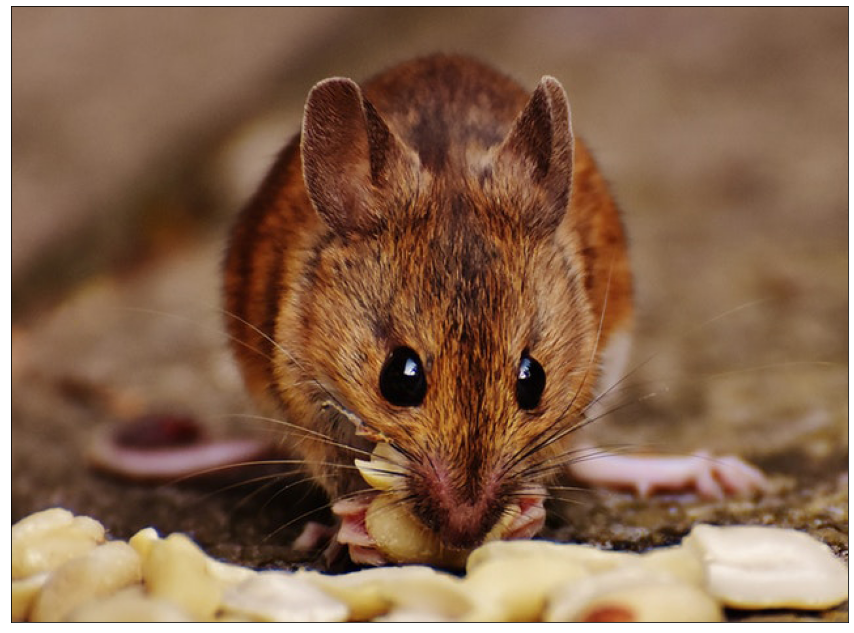

In [131]:
B=8 # blocksize (In Jpeg the
#Convert BGR to RGB
img1 = cv2.imread('Images\mouse.jpg')
transcol = cv2.cvtColor(img1, cv2.COLOR_BGR2YCR_CB)

h,w = transcol.shape[:2]

img2=np.zeros(img1.shape,np.uint8)
img2[:,:,0]=img1[:,:,2]
img2[:,:,1]=img1[:,:,1]
img2[:,:,2]=img1[:,:,0]


print(h,w,'and',img2.shape)
plt.figure(figsize=(15,15));plt.xticks([]),plt.yticks([])
plt.imshow(img2)

In [132]:
SSV=2
SSH=2
crf=cv2.boxFilter(transcol[:,:,1],ddepth=-1,ksize=(2,2))
cbf=cv2.boxFilter(transcol[:,:,2],ddepth=-1,ksize=(2,2))
crsub=crf[::SSV,::SSH]
cbsub=cbf[::SSV,::SSH]
imSub=[transcol[:,:,0],crsub,cbsub]

In [141]:
# Quantization Matrix (Jpeg Standard) Source: Cogranne, R. (2018). Determining JPEG image standard quality factor from the quantization tables. arXiv preprint arXiv:1802.00992.
# 50% compression
QY=np.array([[16,11,10,16,24,40,51,61],
                         [12,12,14,19,26,48,60,55],
                         [14,13,16,24,40,57,69,56],
                         [14,17,22,29,51,87,80,62],
                         [18,22,37,56,68,109,103,77],
                         [24,35,55,64,81,104,113,92],
                         [49,64,78,87,103,121,120,101],
                         [72,92,95,98,112,100,103,99]])

QC=np.array([[17,18,24,47,99,99,99,99],
                         [18,21,26,66,99,99,99,99],
                         [24,26,56,99,99,99,99,99],
                         [47,66,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99]])

QF=10
if QF < 50 and QF > 1:
        scale = np.floor(5000/QF)
elif QF < 100:
        scale = 200-2*QF
else:
        print('Quality Factor must be in the range [1..99]')
scale=scale/100.0
Q=[QY*scale,QC*scale,QC*scale]

In [142]:
TransAll=[]
TransAllQuant=[]
ch=['Y','Cr','Cb']
plt.figure()
for idx,channel in enumerate(imSub):
        channelrows=channel.shape[0]
        channelcols=channel.shape[1]
        Trans = np.zeros((channelrows,channelcols), np.float32)
        TransQuant = np.zeros((channelrows,channelcols), np.float32)
        blocksV= int(channelrows/B)
        blocksH= int(channelcols/B)
        vis0 = np.zeros((channelrows,channelcols), np.float32)
        vis0[:channelrows, :channelcols] = channel
        vis0=vis0-128
        for row in range(blocksV):
                for col in range(blocksH):
                        currentblock = cv2.dct(vis0[row*B:(row+1)*B,col*B:(col+1)*B])
                        Trans[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
                        TransQuant[row*B:(row+1)*B,col*B:(col+1)*B]=np.round(currentblock/Q[idx])
        TransAll.append(Trans)
        TransAllQuant.append(TransQuant)


<Figure size 432x288 with 0 Axes>

In [143]:
DecAll=np.zeros((h,w,3), np.uint8)
for idx,channel in enumerate(TransAllQuant):
        channelrows=channel.shape[0]
        channelcols=channel.shape[1]
        blocksV= int(channelrows/B)
        blocksH= int(channelcols/B)
        back0 = np.zeros((channelrows,channelcols), np.uint8)
        for row in range(blocksV):
                for col in range(blocksH):
                        dequantblock=channel[row*B:(row+1)*B,col*B:(col+1)*B]*Q[idx]
                        currentblock = np.round(cv2.idct(dequantblock))+128
                        currentblock[currentblock>255]=255
                        currentblock[currentblock<0]=0
                        back0[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
        back1=cv2.resize(back0,(w,h))
        DecAll[:,:,idx]=np.round(back1)



Sum of squared error:  8866.762768902752


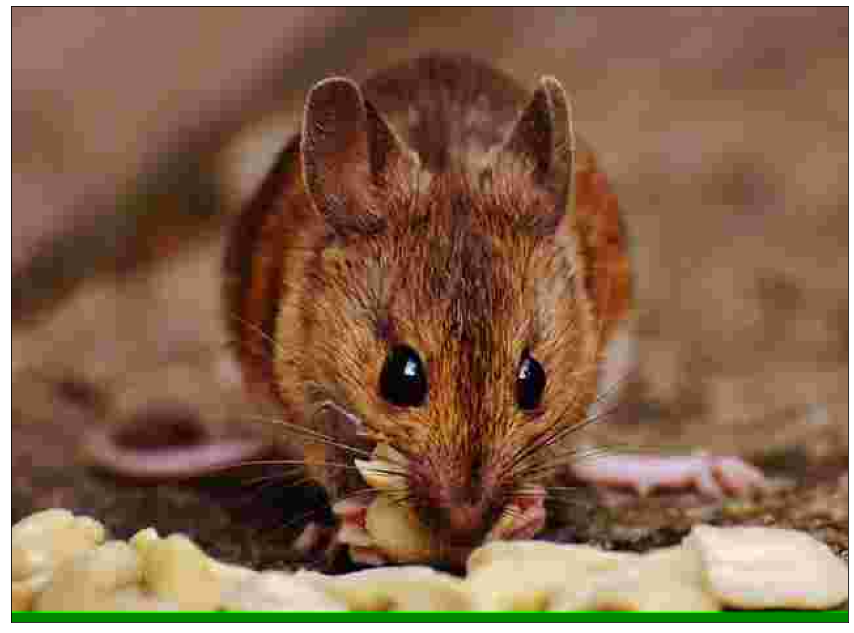

In [144]:
reImg=cv2.cvtColor(DecAll, cv2.COLOR_YCR_CB2BGR) 

img3=np.zeros(img1.shape,np.uint8)
img3[:,:,0]=reImg[:,:,2]
img3[:,:,1]=reImg[:,:,1]
img3[:,:,2]=reImg[:,:,0]

plt.figure(figsize=(15,15));plt.xticks([]),plt.yticks([])
plt.imshow(img3)
SSE=np.sqrt(np.sum((img2-reImg)**2))
print ("Sum of squared error: ",SSE)
plt.show()